In [76]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

In [77]:
data_dir = "D:\Projects\Python\Shape recognizer\shapes"
data_dir = Path(data_dir)

In [78]:
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

300


In [79]:
batch_size = 16
img_height, img_width = 28, 28

In [80]:
train_ds = keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
    )

Found 300 files belonging to 3 classes.
Using 240 files for training.


In [81]:
val_ds = keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
    )

Found 300 files belonging to 3 classes.
Using 60 files for validation.


In [82]:
class_names = train_ds.class_names
print(class_names)

['circles', 'squares', 'triangles']


In [83]:
data_augmentation = keras.Sequential(
    [
        layers.Rescaling(1./255),
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.2),
    ]
)
# Prefetching
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [84]:
input_shape = (img_height, img_width, 1)
num_classes = len(class_names)

# Convert the dataset to grayscale
def convert_to_grayscale(image, label):
    image = tf.image.rgb_to_grayscale(image)
    return image, label
train_ds = train_ds.map(convert_to_grayscale)
val_ds = val_ds.map(convert_to_grayscale)

model = models.Sequential([
        layers.Conv2D(16, (3, 3), input_shape=input_shape, activation='sigmoid', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(32, (3, 3), activation='sigmoid', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='sigmoid', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='sigmoid', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(64, activation='sigmoid'),
        layers.Dropout(0.3),  # Regularization for small dataset
        layers.Dense(num_classes, activation='softmax')
    ])
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [85]:
epochs = 60
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.3619 - loss: 1.1519 - val_accuracy: 0.3000 - val_loss: 1.1081
Epoch 2/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5679 - loss: 0.8958 - val_accuracy: 0.3000 - val_loss: 1.1021
Epoch 3/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7022 - loss: 0.6807 - val_accuracy: 0.3500 - val_loss: 1.0992
Epoch 4/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8399 - loss: 0.4938 - val_accuracy: 0.5000 - val_loss: 1.0950
Epoch 5/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9588 - loss: 0.2554 - val_accuracy: 0.3000 - val_loss: 1.0967
Epoch 6/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9876 - loss: 0.1483 - val_accuracy: 0.3000 - val_loss: 1.0933
Epoch 7/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9745 - loss: 0.1255 - val_accuracy: 0.3000 - val_loss: 1.0972
Epoch 8/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0669 - val_accuracy: 0.3000 - val_loss

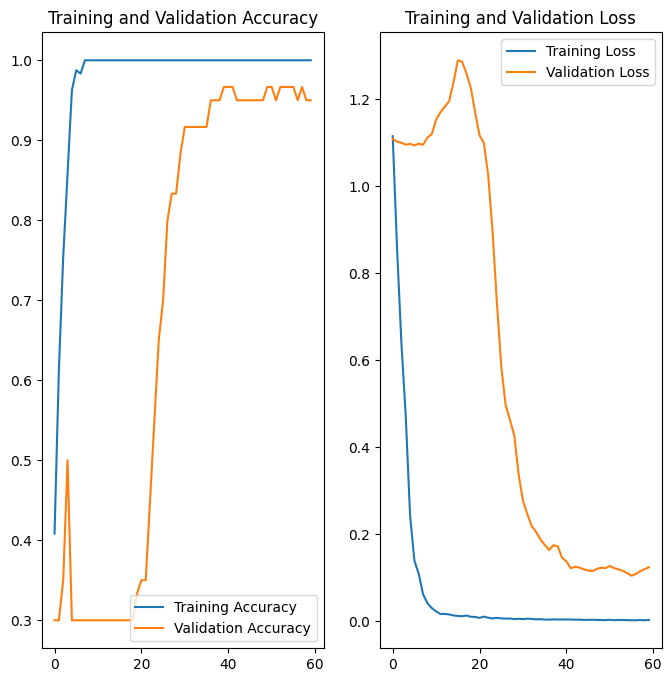

In [86]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [87]:
for images, labels in val_ds.take(4):
    predictions = model.predict(images)
    predicted_labels = tf.argmax(predictions, axis=1)

    print("Predicted:  ", predicted_labels.numpy())
    print("True labels:", labels.numpy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
Predicted:   [2 2 2 1 2 1 1 0 0 2 1 1 2 1 2 1]
True labels: [2 2 2 1 2 1 1 0 0 2 1 1 2 1 2 1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predicted:   [0 0 2 1 1 2 1 0 2 0 0 0 1 0 2 2]
True labels: [0 0 0 1 1 2 1 0 2 0 0 0 1 2 2 2]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted:   [1 1 1 1 0 1 0 2 0 0 1 1 2 0 0 1]
True labels: [1 1 1 1 0 1 0 2 0 0 1 1 2 0 0 1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
Predicted:   [2 0 2 0 0 1 2 1 0 0 0 0]
True labels: [2 0 2 0 0 1 2 1 0 0 0 2]


In [ ]:
# model.save("shape_recognizer.keras")